In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.13.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


[Chinese Buyers Are Ordering Nvidia’s Newest AI Chips, Defying U.S. Curbs](https://www.wsj.com/tech/china-nvidia-blackwell-chips-ai-531fed0c)

___

[Virtual Reality Goggles for Your Mouth](https://www.nytimes.com/2025/02/28/science/taste-virtual-reality-tongue.html)

___

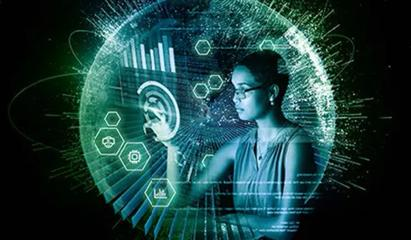

[Finance insights engines and other AI applications](https://www.cfodive.com/spons/the-ai-revolution-in-finance-what-cfos-need-to-know-now/741137/) - CFO Dive

___

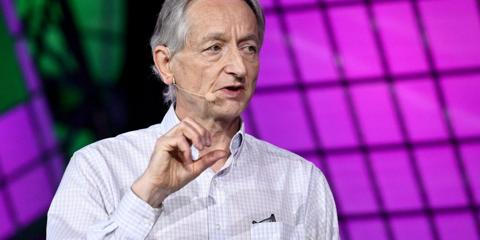

[Elon Musk seems about to be expelled from the Royal Society after attacks on NIH, Fauci, Nazi salutes etc.

not sure it's Hinton who is careless and ignorant and cruel tbh](https://fortune.com/europe/2025/03/03/elon-musk-labels-geoffrey-hinton-carelessly-ignorant-cruel-godfather-ai-calls-him-banished-royal-society/) - Fortune Europe

___

[A tumbleweed robot for field work in challenging terrain on Earth or even the moon and Mars](https://actu.epfl.ch/news/morphing-robot-turns-challenging-terrain-to-its--2/)

___

[Hallucinations in code are the least of your problems. Subtle errors are worse, never trust anything and test everything.](https://simonwillison.net/2025/Mar/2/hallucinations-in-code/) - Simon Willison’s Weblog

___

[AI spots fires. 

Fire lookout was a great job for outdoorsy introverts, so much for that I guess.](https://www.wsj.com/tech/ai/these-ai-cameras-detect-wildfires-before-they-spread-6b6e3229)

___

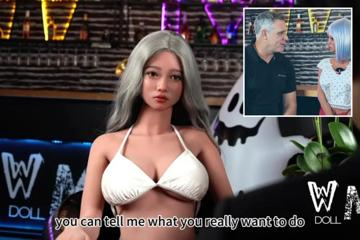

[hmmh](https://nypost.com/2025/03/02/tech/new-ai-powered-talking-sex-doll-can-comfort-users-who-climax-too-quickly-two-minutes-is-awesome/) - New York Post

___

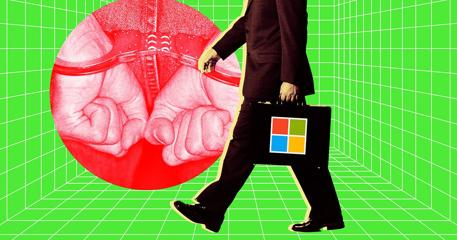

[Microsoft Is Suing Jailbreakers](https://futurism.com/microsoft-suing-ai) - Futurism

___

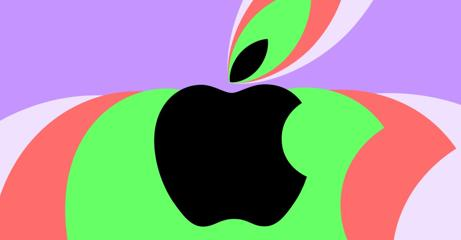

[Siri upgrade seen a long way off](https://www.theverge.com/news/622465/siris-real-ai-upgrade-could-still-be-years-away) - The Verge

___

not bad

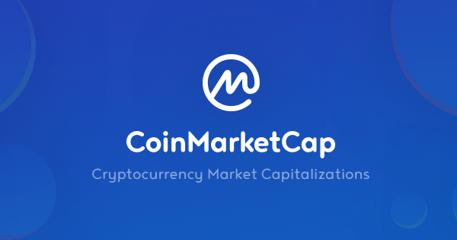

[Found the final bagholder for the And It's Gone coin](https://coinmarketcap.com/currencies/and-its-gone/) - CoinMarketCap

___

An in-depth look at Apple's AI crisis, as some in Apple's AI division believe that a true conversational "LLM Siri" won't be ready until iOS 20 at best in 2027 (Mark Gurman/Bloomberg)

Main Link | Techmeme Permalink

America's greatest export and source of soft (and hard power) is the dollar, so let's undermine it while writing a giant check to the biggest scammers the world has ever known. Yeah social security is the real ponzi scheme, not Trump shitcoins.

yay a strategic magic bean reserve

@garethwatkins.bsky.social gandhi not ghandi dammit

MAGA bitches!

Thank you @Potus for your exemplary AI leadership, for standing up for American tech leadership in a way that no President has ever had the courage to do before. Thank you for putting America First. America is with you!

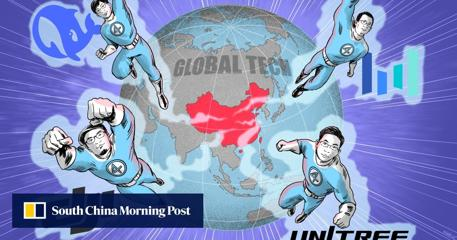

[China's 'Fantastic Four' tech entrepreneurs](https://www.scmp.com/tech/big-tech/article/3300594/chinas-fantastic-four-new-breed-entrepreneurs-reshaping-global-tech-landscape) - South China Morning Post

___

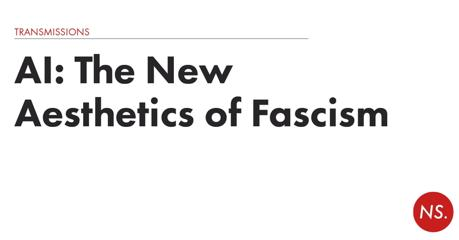

[AI and the modern fascist, a perfect match made in hell](https://newsocialist.org.uk/transmissions/ai-the-new-aesthetics-of-fascism/) - New Socialist

___

[What happens when intelligence is free? Currently best case is AI is a force multiplier. You drop the cost of some tasks by an order of magnitude, it pushes the envelope, but it doesn't end scarcity. Energy and other constraints become a limiting factor.](https://www.bloomberg.com/news/articles/2025-02-28/how-ai-reasoning-models-will-change-companies-and-the-economy)

___

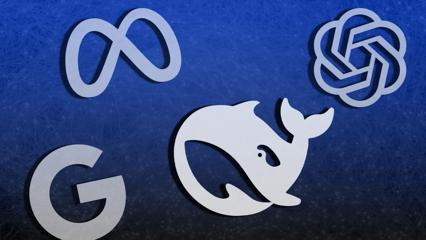

[AI firms apply distillation to make models cheaper and faster, and to copy others' models.](https://www.ft.com/content/c117e853-d2a6-4e7c-aea9-e88c7226c31f)

___

[Upload a VB executable to Claude, get python back](https://www.reddit.com/r/ClaudeAI/comments/1iyumpf/i_uploaded_a_27yearold_exe_file_to_claude_37_and/)

___

[Oscars rekindle controversies over AI in films.](https://www.fastcompany.com/91286148/everything-you-need-to-know-about-the-oscars-ai-controversy)

___

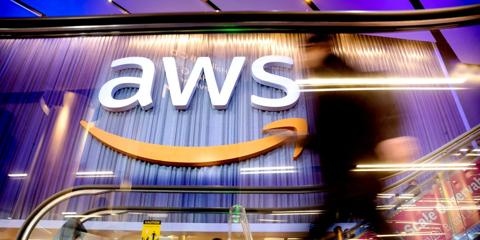

[AWS on how  financial firms are using AI](https://www.businessinsider.com/aws-wall-street-jpmorgan-bridgewater-mufg-rocket-mortgage-2025-2) - Business Insider

___

normalize launching Nazis into the sun

when people get wise these barbarians are getting launched into the sun

what I did this week

fired the people modeling hurricanes and curing cancer

cut off AIDS drugs and oxygen talks

fed the agencies with tech veterans actually making 
government more efficient into the wood chipper

cozied up to Putin and smeared the people he invaded who are dying for freedom

[AI said to improve code quality but doesn't save time on reviews.](https://avikalpg.github.io/blog/articles/20250301_ai_code_reviews_vs_code_review_interfaces.html)

___

[Masa Son wants to borrow \\$16b.](https://www.theinformation.com/articles/softbanks-son-goes-on-a-new-borrowing-binge-to-fund-ai)

___

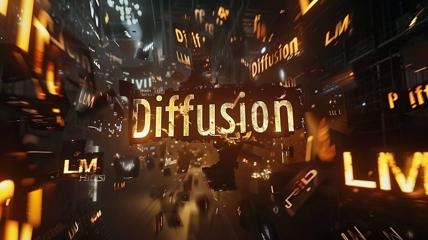

[Inception Labs releases Mercury Coder, a diffusion LLM breaking from the transformer approach.](https://hackernoon.com/what-is-a-diffusion-llm-and-why-does-it-matter)

___

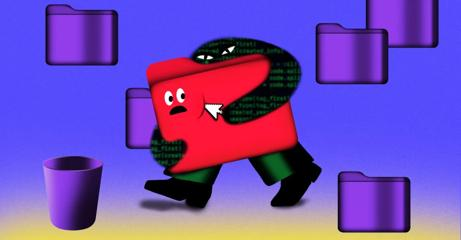

[You can get a lot of juice for the squeeze writing AI agents in the cloud with Zapier and other services but ya know, you hook it up to Netsuite where you do accounting and connect to banks, and CRM and HR and payroll stuff and then blammo](https://www.theverge.com/news/622026/zapier-data-breach-code-repositories) - The Verge

___

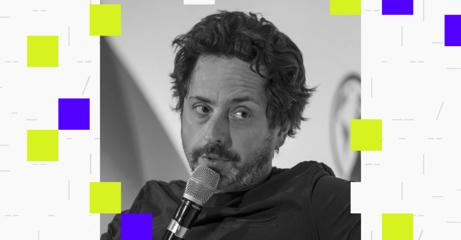

[also said to stop building so much safety and trust users](https://www.theverge.com/command-line-newsletter/622045/google-ai-nanny-products) - The Verge

___

[When Google came out in 1998 she searched for her name and was shocked](https://www.clashmusic.com/features/im-truly-grateful-looking-back-with-vashti-bunyan/)

___

[who says robots need 5 fingers](https://www.reddit.com/r/oddlysatisfying/comments/1j0m529/octopusinspired_robotic_arm/)

___

fuck, marry, kill
Haskell
Python
JavaScript

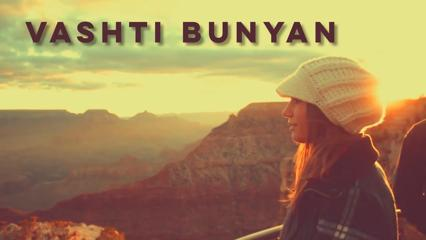

[Happy 80th birthday to Vashti Bunyan! www.youtube.com/watch?v=6A6N...

Made an album at 25, it went nowhere, she abandoned the music business, raised kids, the album slowly gained a cult following, 30 years later did a followup and had a successful music career](https://www.youtube.com/watch?v=6A6N4dunDxU) - YouTube

___

[Brin says Google can reach AGI if everyone is in the office 60 hours per week.](https://www.nytimes.com/2025/02/27/technology/google-sergey-brin-return-to-office.html?unlocked_article_code=1.0U4.A8Eb.6hfgL-MPLsba&smid=url-share&utm_source=tldrnewsletter)

___

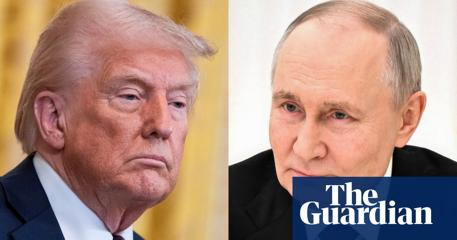

[Putin no longer a cybersecurity threat, he is on the inside with Musk and Big Balls](https://www.theguardian.com/us-news/2025/feb/28/trump-russia-hacking-cyber-security) - the Guardian

___

[FIne-tuning and serving a small DeepSeek model locally](https://www.kdnuggets.com/how-to-fine-tune-deepseek-r1-custom-dataset)

___

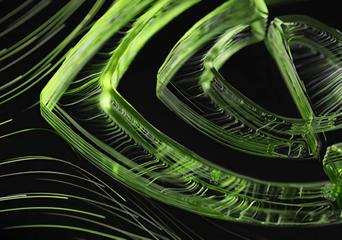

[Nvidia teases big midcycle B300 upgrade, 2026 Vera Rubin architecture.](https://www.techspot.com/news/106960-nvidia-confirms-blackwell-ultra-launch-teases-vera-rubin.html) - TechSpot

___

[Founder of Unitree gets Xi Jinping boost](https://finance.yahoo.com/news/unitree-robots-dance-fight-earn-104314941.html)

___

[ChatGPT in 2030](https://www.reddit.com/r/ChatGPT/comments/1j0wq6a/chatgpt_in_2030/)

___

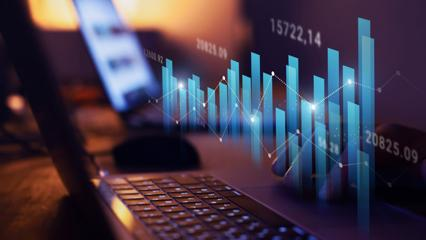

[Using AI to analyze financial reports.](https://www.ft.com/content/c41b372c-946d-47ea-9fbd-bd11a19d6828)

___

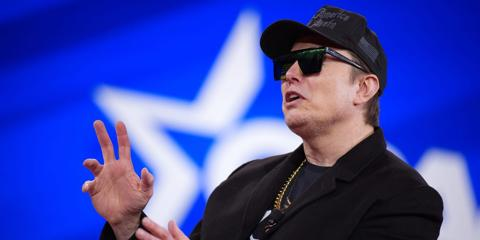

[On Rogan, Elon Musk says there's 'only a 20% chance of annihilation' with AI](https://www.businessinsider.com/elon-musk-only-chance-of-annihilation-with-ai-2025-2) - Business Insider

___

[Fake images from the past cause a loss of trust in historical narratives.

(Forrest Gump didn't really meet LBJ)](https://www.latimes.com/opinion/story/2025-03-01/documentary-film-artificial-intelligence-hollywood-archival-producers-alliance)

___

[Sharing stuff on GitHub is OK though.](https://www.bloomberg.com/news/articles/2025-03-01/deepseek-reveals-theoretical-margin-on-its-ai-models-is-545)

___

[China tells AI leaders not to travel to US](https://www.wsj.com/world/china/china-ai-us-travel-advisory-ff248349)

___

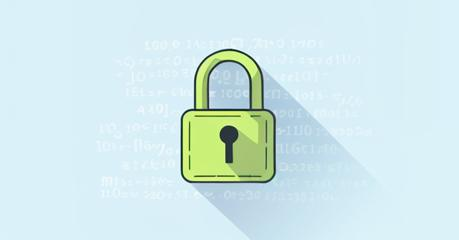

[Datasets used to train AI found to have 12,000+ live API keys and passwords](https://thehackernews.com/2025/02/12000-api-keys-and-passwords-found-in.html) - The Hacker News

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [11]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [12]:
print(datetime.now())

2025-03-03 07:52:33.585364


In [13]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2025, 3, 3, 12, 47, 53, 378000)

In [14]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2025-03-02 01:52:33.592912


In [15]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [16]:
a

{'x': 1, 'y': 2}

In [17]:
b



NameError: name 'b' is not defined